In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
import collections
import string
from collections import OrderedDict
from mpl_toolkits import mplot3d
import random
import scipy.interpolate
import pandas as pd
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

In [2]:
def readColumnsFromFile(filename):
    
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=",")
        
        first_line = next(reader)
        has_headers = "#" in first_line[0]
        ncol=len(first_line) # Read first line and count columns
        if not has_headers:
            infile.seek(0)
        #print(first_line)
        #infile.seek(0) 
        #has_header = csv.Sniffer().has_header(infile.read(1024))
        #infile.seek(0)
        #if has_header:
         #   next(reader)
        
        all_cols = [[] for x in range(ncol)]
        
        for row in reader:
            row_data = [float(col.strip()) for col in row] 
            all_cols = [listo+[data] for listo, data in zip(all_cols, row_data)]
            
        if has_headers:
            first_line[0] = first_line[0].replace("#", "")
            first_line = [fl.strip() for fl in first_line]
            return first_line, all_cols
        else:
            return all_cols

In [3]:
def readColumnsFromFilesIntoDict(filename):
    
    columns = []
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=',')
        
        for row in reader:
            if columns:
                for i, value in enumerate(row):
                    columns[i].append(float(value.strip()))
            else:
                #enter here if columns is false, i.e. is empty
                columns = [[header.replace("#", "").strip()] for header in row]
    
    return {c[0] : c[1:] for c in columns}
  

varyKandDR_tau001 = readColumnsFromFilesIntoDict('data/varying_detRate-(0.0020-0.0040)_and_thresholdK-(0.4000-0.9000).txt')
varyKandDR_tau001_v2 = readColumnsFromFilesIntoDict('data/varying_detRate-(0.0020-0.0040)_and_thresholdK-(0.4000-0.9000)-tau=0.01.txt')
varyKandDR_tau005 = readColumnsFromFilesIntoDict('data/varying_detRate-(0.0020-0.0040)_and_thresholdK-(0.4000-0.9000)-tau=0.05.txt')
varyKandDR_tau01 = readColumnsFromFilesIntoDict('data/varying_detRate-(0.0020-0.0040)_and_thresholdK-(0.4000-0.9000)-tau=0.1.txt')
varyKandDR_tau02 = readColumnsFromFilesIntoDict('data/varying_detRate-(0.0020-0.0040)_and_thresholdK-(0.4000-0.9000)-tau=0.2.txt')
vary_dict_list = [varyKandDR_tau001, varyKandDR_tau005, varyKandDR_tau01, varyKandDR_tau02]
varying_tau_data = readColumnsFromFilesIntoDict('data/varying_tauStep-(0.0100-1.2000).txt')
print(varying_tau_data['n_tau_halves'])

[1.2, 7.5, 10.15, 8.75, 13.6, 21.3, 14.7, 32.45, 27.3, 45.05, 69.85, 57.05, 64.1, 93.0, 67.1, 79.4, 83.6, 91.75, 151.45, 73.6, 124.1, 124.45, 132.2, 139.1, 193.75, 151.45, 125.05, 142.45, 198.9, 171.45, 130.85, 237.5, 175.5, 198.15, 145.5, 207.25, 146.45, 320.15, 211.3, 294.25, 184.8, 238.85, 310.05, 283.7, 384.3, 197.25, 235.5, 278.45, 201.9, 285.45, 368.3, 399.9, 312.4, 362.25, 318.4, 376.8, 231.45, 502.6, 266.35, 482.6, 474.7, 476.5, 552.8, 416.05, 337.05, 475.15, 628.95, 538.55, 524.7, 594.2, 499.55, 428.2, 353.0, 425.75, 579.9, 516.9, 532.75, 268.2, 301.9, 514.85, 379.75, 374.6, 320.1, 654.65, 383.9, 416.1, 575.25, 713.8, 465.9, 597.95, 314.25, 614.55, 349.2, 556.1, 449.1, 375.3, 561.0, 542.1, 522.65, 482.5, 537.4, 634.8, 718.1, 246.45, 756.2, 705.95, 829.4, 486.4, 502.1, 821.0, 955.55, 501.05, 422.15, 673.1, 658.85, 525.35, 583.9, 712.8, 878.2]


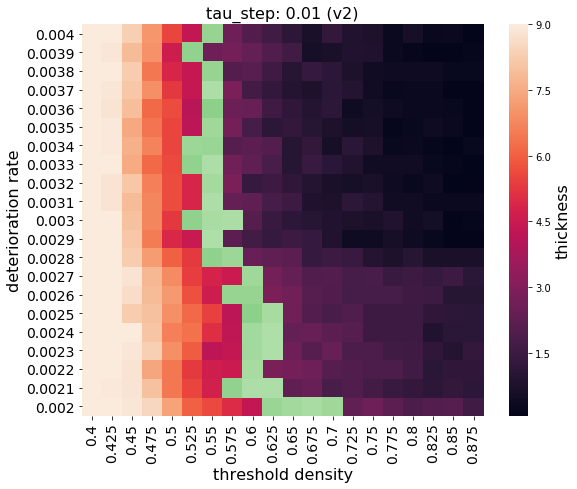

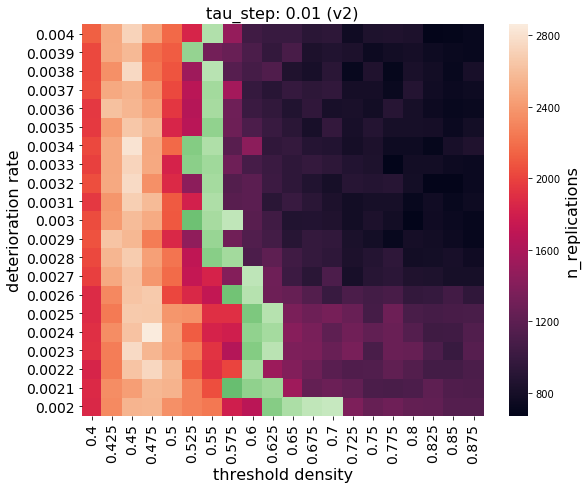

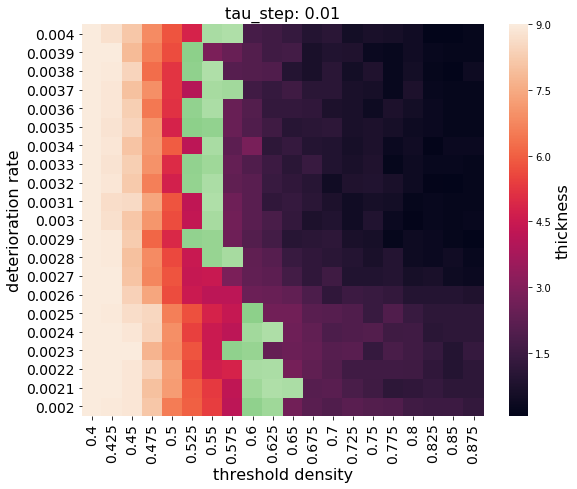

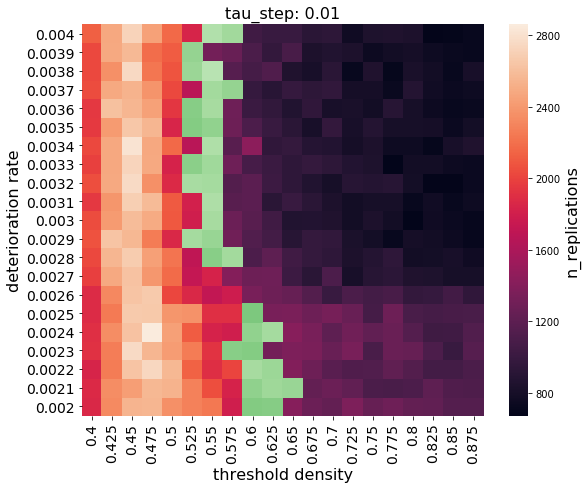

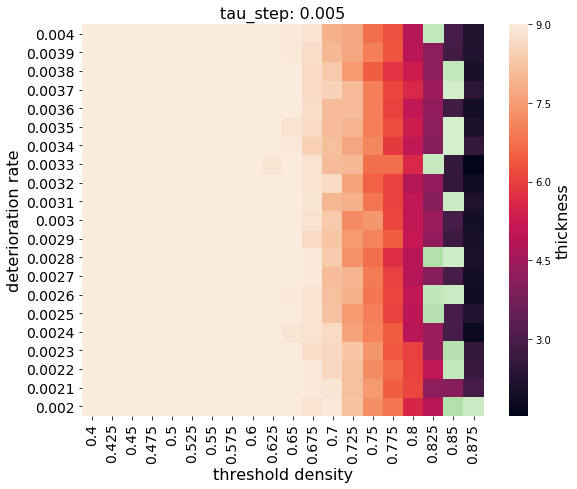

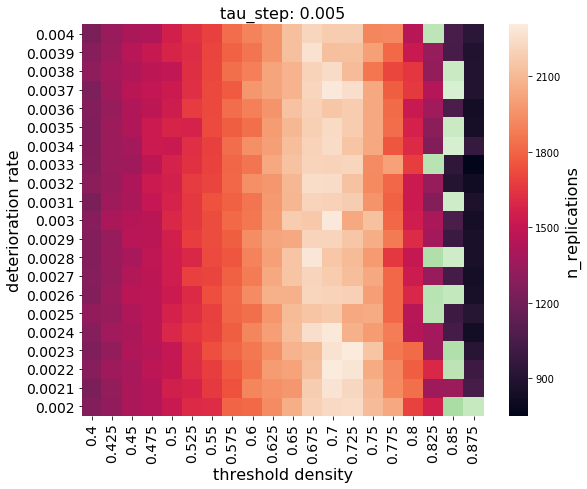

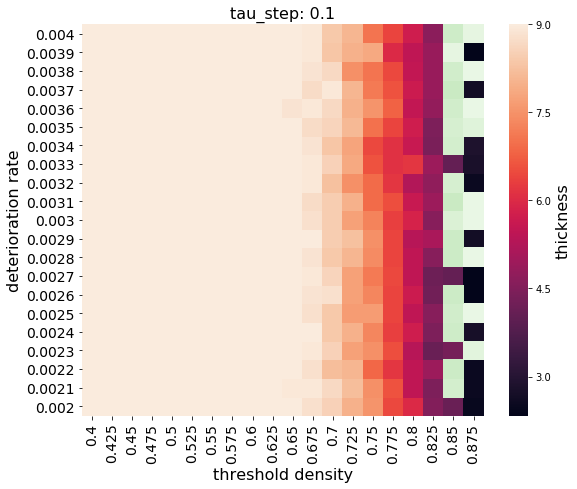

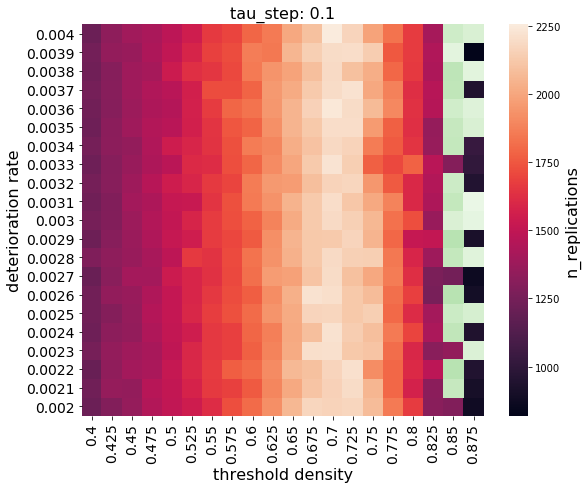

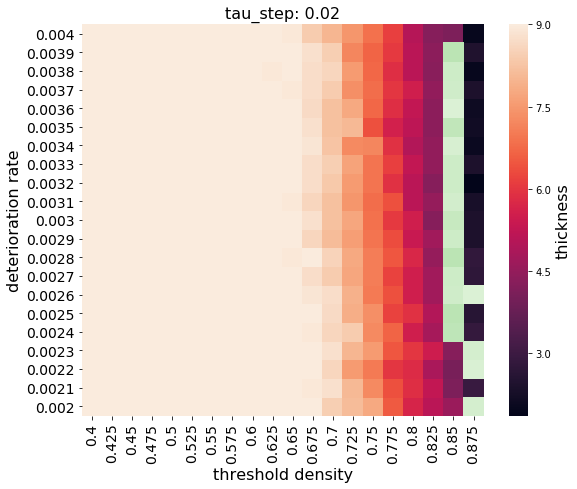

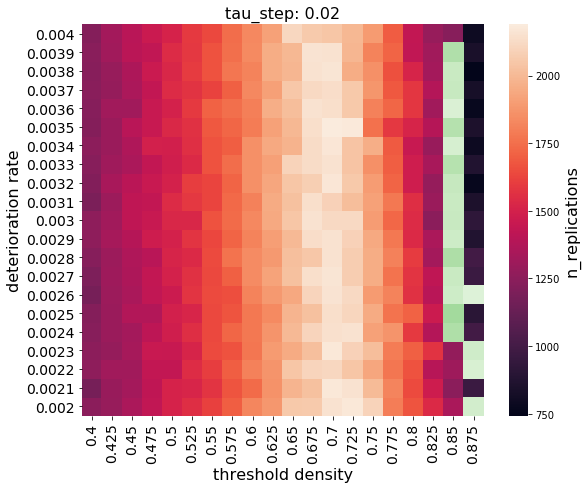

In [9]:
def plotKAndDetRColourMap_2(all_values, z_key, masky=None, id_filters=None, tau_val=""):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 7.2)
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12

    k_key = 'K*' if 'K*' in all_values.keys() else 'K'
    x_raw = all_values[k_key]
    y_raw = all_values['det_rate']
    z_raw = all_values[z_key]
    
    
    
    
    ### this region plots the whole thing
    data = pd.DataFrame({'K*': x_raw, 'det_rate': y_raw, z_key: z_raw})
    data_pivoted = data.pivot("K*", "det_rate", z_key).transpose()
    #if no mask is provided, then this selects thickness values between 3 and 4
    #if a mask is returned, then it uses that mask, like for colouring the corresponding replication values
    masko = (data_pivoted < 3) | (data_pivoted > 4) if (masky is None) else masky
    
    ##### now we filter out some values to focus on regions of interest
    
    x_arr = np.array(x_raw)
    y_arr = np.array(y_raw)
    z_arr = np.array(z_raw)
    

    #this section plots a zoomed in section
#     id_x = (x_arr >=0.5) & (x_arr <=0.65) if (id_filters is None) else id_filters
#     x_filter = x_arr[id_x]
#     y_filter = y_arr[id_x]
#     z_filter = z_arr[id_x]
    
#     data_filter = pd.DataFrame({'K*': x_filter, 'det_rate': y_filter, z_key: z_filter})
#     data_filter_pivoted = data_filter.pivot("K*", "det_rate", z_key).transpose() #swapped x and y data to better display annotations
#     masko_filter = (data_filter_pivoted < 3) | (data_filter_pivoted > 4) if (masky is None) else masky

    filtered=False
    h_map = sns.heatmap(data_pivoted, annot=False, fmt=".1f")
    masked_map = sns.heatmap(data_pivoted, mask = masko, cmap='Greens', cbar=False)
#     filtered=True
#     h_map = sns.heatmap(data_filter_pivoted, annot=True, fmt=".1f")
#     masked_map = sns.heatmap(data_filter_pivoted, mask = masko_filter, cmap='Greens', cbar=False, annot=True,fmt=".1f")
    
    
    
    ax.set_title("tau_step: "+tau_val, fontsize=titleSize)
    ax.invert_yaxis()
    ax.set_ylabel('deterioration rate', fontsize=labelSize)
    ax.set_xlabel('threshold density', fontsize=labelSize)
    ax.collections[0].colorbar.set_label(z_key, fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    

#     if filtered:
#         plt.savefig('plots/squares_'+z_key+'_filtered.pdf', bbox_inches='tight')
#     else:
#         plt.savefig('plots/squares_'+z_key+'.pdf', bbox_inches='tight')
    plt.show()
    #if masky is None and filtered: return (masko_filter, id_x) else (masko)
    return (masko_filter, id_x) if (masky is None and filtered) else (masko, None)
    


masko, id_x = plotKAndDetRColourMap_2(varyKandDR_tau001_v2, 'thickness', tau_val="0.01 (v2)")
#_ = plotKAndDetRColourMap_2(varyKandDR_tau001, 'thick_stDev', masky=masko, id_filters=id_x)
_ = plotKAndDetRColourMap_2(varyKandDR_tau001, 'n_replications', masky=masko, id_filters=id_x, tau_val="0.01 (v2)")

masko, id_x = plotKAndDetRColourMap_2(varyKandDR_tau001, 'thickness', tau_val="0.01")
#_ = plotKAndDetRColourMap_2(varyKandDR_tau001, 'thick_stDev', masky=masko, id_filters=id_x)
_ = plotKAndDetRColourMap_2(varyKandDR_tau001, 'n_replications', masky=masko, id_filters=id_x, tau_val="0.01")

masko, id_x = plotKAndDetRColourMap_2(varyKandDR_tau005, 'thickness', tau_val="0.005")
#_ = plotKAndDetRColourMap_2(varyKandDR_tau005, 'thick_stDev', masky=masko, id_filters=id_x)
_ = plotKAndDetRColourMap_2(varyKandDR_tau005, 'n_replications', masky=masko, id_filters=id_x, tau_val="0.005")

masko, id_x = plotKAndDetRColourMap_2(varyKandDR_tau01, 'thickness', tau_val="0.1")
#_ = plotKAndDetRColourMap_2(varyKandDR_tau01, 'thick_stDev', masky=masko, id_filters=id_x)
_ = plotKAndDetRColourMap_2(varyKandDR_tau01, 'n_replications', masky=masko, id_filters=id_x, tau_val="0.1")

masko, id_x = plotKAndDetRColourMap_2(varyKandDR_tau02, 'thickness', tau_val="0.02")
#_ = plotKAndDetRColourMap_2(varyKandDR_tau02, 'thick_stDev', masky=masko, id_filters=id_x)
_ = plotKAndDetRColourMap_2(varyKandDR_tau02, 'n_replications', masky=masko, id_filters=id_x, tau_val="0.02")

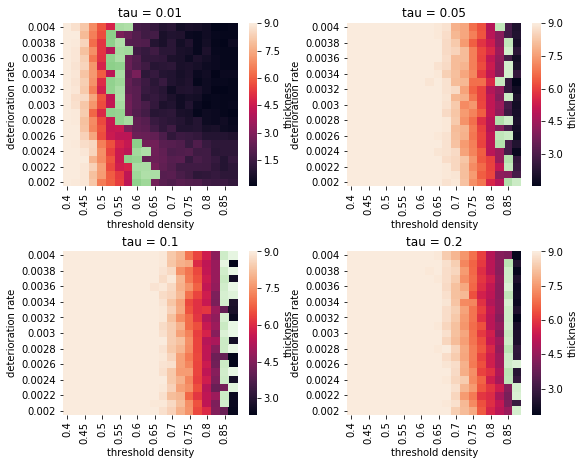

In [55]:
def plot4ColourMaps(dict_list, tau_list, z_key, masky=None, id_filters=None):
    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.set_size_inches(9, 7.2)
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12

    for i in range(1, len(dict_list)+1):
        dicto = dict_list[i-1]
        ax = fig.add_subplot(2, 2, i)
        k_key = 'K*' if 'K*' in dicto.keys() else 'K'
        x_raw = dicto[k_key]
        y_raw = dicto['det_rate']
        z_raw = dicto[z_key]
        
        ### this region plots the whole thing
        data = pd.DataFrame({'K*': x_raw, 'det_rate': y_raw, z_key: z_raw})
        data_pivoted = data.pivot("K*", "det_rate", z_key).transpose()
        #if no mask is provided, then this selects thickness values between 3 and 4
        #if a mask is returned, then it uses that mask, like for colouring the corresponding replication values
        masko = (data_pivoted < 3) | (data_pivoted > 4) if (masky is None) else masky
        
        filtered=False
        h_map = sns.heatmap(data_pivoted, annot=False, fmt=".1f")
        masked_map = sns.heatmap(data_pivoted, mask = masko, cmap='Greens', cbar=False)
        ax.invert_yaxis()
        ax.set_ylabel('deterioration rate')
        ax.set_xlabel('threshold density')
        ax.collections[0].colorbar.set_label(z_key)
        #ax.xaxis.set_major_formatter(ScalarFormatter())
        #ax.yaxis.set_major_formatter(ScalarFormatter())
        #ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_title('tau = '+str(tau_list[i-1]))
        #ax.xaxis.set_tick_params(labelsize=numbersize)
        #ax.yaxis.set_tick_params(labelsize=numbersize)
        
    plt.savefig('plots/various_tau_heatmaps.pdf', bbox_inches='tight')
    plt.show()

tau_list = [0.01, 0.05, 0.1, 0.2]
plot4ColourMaps(vary_dict_list, tau_list, 'thickness')

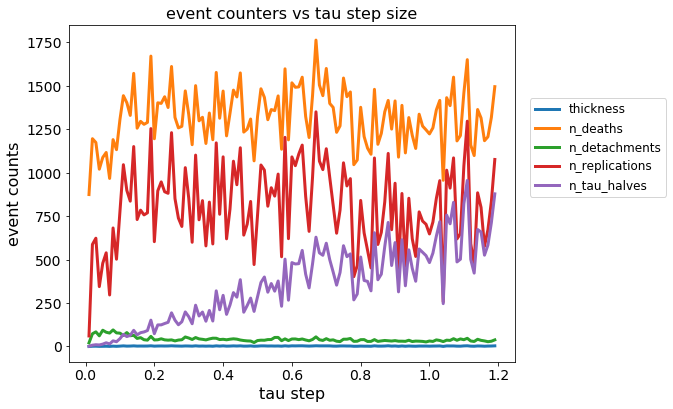

In [54]:
def plotVaryingTauCounters(tau_data):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    
    tau_steps = tau_data['tau']
    features_to_plot = ['thickness', 'n_deaths', 'n_detachments', 'n_replications', 'n_tau_halves']
    
    for feature in features_to_plot:
        ax.plot(tau_steps, tau_data[feature], label=feature, linewidth=3)
    
    plt.legend(fontsize='large', bbox_to_anchor=(1.02,0.8))
    ax.yaxis.set_tick_params(labelsize=numbersize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    plt.title('event counters vs tau step size', fontsize=titleSize)
    plt.xlabel('tau step', fontsize=labelSize)
    plt.ylabel('event counts', fontsize=labelSize)
    plt.savefig('plots/varying_tau_step_event_counts.pdf', bbox_inches='tight')
    plt.show()
    
plotVaryingTauCounters(varying_tau_data)

***
***
# everything below this is outdated
***
***

[[9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0
  9.0 9.0 9.0]
 [8.9333 9.0 9.0 9.0 9.0 8.9333 9.0 9.0 8.9333 8.9333 8.7333 8.6667
  8.8667 8.8 8.8667 8.8 8.8667 8.8667 8.9333 9.0 8.7333]
 [8.8667 8.8667 8.8667 9.0 8.8667 8.6667 8.4 8.0667 8.0 8.2667 8.1333 8.6
  8.2 8.3333 8.0667 8.4667 8.3333 8.0 8.4667 7.8667 8.1333]
 [8.1333 8.0 8.4 7.7333 8.4667 8.5333 7.4 6.7333 6.8667 6.1333 7.0667 7.4
  6.6 7.0 7.1333 7.0667 6.4667 6.9333 6.2667 6.6 6.8667]
 [6.5333 7.2 7.2667 6.8667 6.9333 6.6 5.6667 5.8 5.6 4.9333 5.6667 5.8
  4.7333 5.0 5.9333 4.8 5.1333 5.2 5.2 5.6667 5.8]
 [6.0 5.9333 5.6 5.8 5.4667 5.7333 4.5333 4.4 4.4667 -- 4.3333 4.2667 --
  -- 4.2 -- -- 4.0667 -- -- 4.8]
 [5.4 5.3333 4.6667 4.5333 4.5333 4.8 4.2 4.4667 -- -- -- -- -- -- -- --
  -- -- -- 2.8667 --]
 [4.2 4.2667 4.8 -- 4.2 4.4 4.2 2.8667 -- 2.6 2.6667 2.6 2.2667 2.4 2.2
  2.4667 2.4667 -- 2.0667 2.4667 --]
 [-- -- -- -- -- -- 2.5333 2.3333 2.2667 2.0 2.1333 2.1333 2.1333 1.9333
  2.8 1.9333 2.0

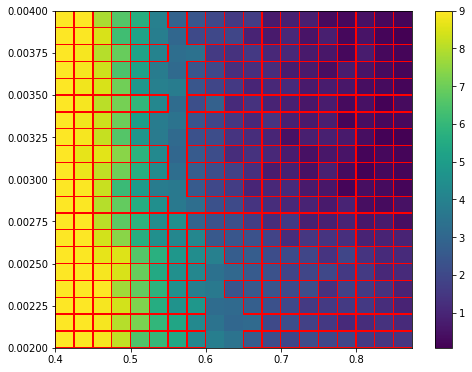

[[1863.6 1871.5 1841.1 1915.1 1911.0 1880.7 1878.4 1986.4 2030.8 2068.2
  2043.2 1953.7 2052.5 1993.3 2028.8 1959.9 1952.1 2040.7 2031.1 2025.1
  2129.1]
 [2326.5 2340.6 2261.3 2270.8 2339.5 2245.6 2322.1 2491.7 2554.4 2631.4
  2412.5 2386.0 2489.3 2477.1 2477.5 2416.2 2617.7 2484.7 2360.8 2487.6
  2479.2]
 [2545.2 2430.0 2631.9 2762.8 2622.9 2672.4 2633.8 2628.7 2675.3 2566.7
  2591.7 2696.7 2761.5 2729.8 2815.3 2649.6 2555.9 2543.7 2750.5 2575.5
  2718.3]
 [2561.3 2563.6 2745.7 2555.3 2860.5 2660.3 2664.3 2397.3 2439.7 2255.5
  2494.0 2583.5 2358.5 2488.7 2482.9 2555.2 2443.7 2381.4 2230.5 2192.6
  2446.3]
 [2364.0 2541.1 2567.5 2422.3 2438.0 2382.4 2021.3 2177.8 2226.5 1866.5
  2096.7 2100.7 1872.6 1830.0 2168.6 1846.2 1943.6 2025.5 2074.7 2114.8
  2169.3]
 [2283.8 2285.4 2135.5 2255.7 2117.1 2367.7 1864.0 1730.3 1698.9 1462.1
  1796.1 1814.7 1448.5 1624.5 1665.2 1668.6 1653.6 1680.7 1531.3 1569.8
  1836.7]
 [2238.5 2052.5 1898.0 1923.1 1829.5 1910.0 1721.5 1835.1 1639.9 1546.7
  14

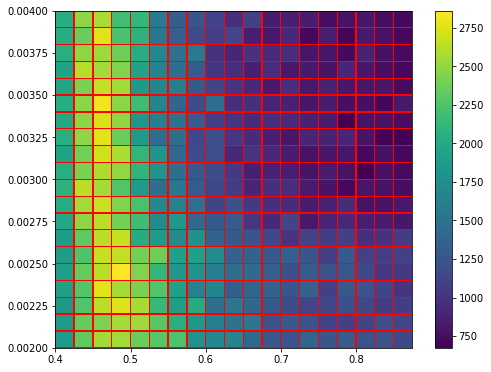

In [60]:
def plotKAndDetRColourMap(all_values, z_key, mask=True):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    #need to reshape the 1d lists to that they're of size m x n
    #where m is the number of unique x values and n is the number of times each unique value appears
    x_raw = all_values['K']
    y_raw = all_values['det_rate']
    z_raw = all_values[z_key]
    
    dx = (x_raw[0] - x_raw[1])/2.
    dy = (y_raw[0] - y_raw[1])/2.
    extent = [x_raw[0]-dx, x_raw[-1]+dx, y_raw[0]-dy, y_raw[-1]+dy]
    m = len(set(all_values['K']))
    n = int(len(all_values['K'])/m)
    z = np.array(all_values[z_key]).reshape(m,n)

    x = np.array(all_values['K']).reshape(m,n)
    y = np.array(all_values['det_rate']).reshape(m,n)
    z = np.array(all_values[z_key]).reshape(m,n)
    cmap = ax.pcolor(x,y,z)
    fig.colorbar(cmap)
    goldilocks_bools = ((z >=3) & (z<=4))
    goldilocks_zone = np.ma.array(z, mask=goldilocks_bools)
    print(goldilocks_zone)
    
    gl_zone = ax.pcolor(x,y,goldilocks_zone,color='red',facecolor='red')
    #print(goldilocks_zone)
    #tc = ax.tripcolor(x_raw,y_raw,z_raw,9)
    #fig.colorbar(tc)
#     imshow_graph = ax.imshow(z[::-1,::])
#     cbar = fig.colorbar(imshow_graph)
    
    #colour_map = ax.contourf(x, y, z,10)
    #cbar = fig.colorbar(colour_map)
    
    #if mask: coloured_goldilocks = ax.contourf(x,y,goldilocks_zone, colors='green')
    plt.savefig('plots/squares'+z_key+'.pdf', bbox_inches='tight')
    plt.show()
    
plotKAndDetRColourMap(testo, 'thickness')
plotKAndDetRColourMap(testo, 'n_replications', mask=False)

In [3]:
def combineAndAverageResultsArrays(resultsA, resultsB):
    
    combined_data = []
    
    for i in range(len(resultsA)):
        combined_subresult = [(x+y)/2. for x,y in zip(resultsA[i], resultsB[i])]
        combined_data.append(combined_subresult)
        
    return combined_data
        

In [4]:
event_counters_labels_testing = readColumnsFromFile('data/pyrithione-bf-thickness_histo-t=1680.0-parallel-event_counters.txt')
event_counters_labels_99res = readColumnsFromFile('data/pyrithione-t=1680.0-parallel-event_counters_sigma=0.56003.txt')
event_counters_labels_95res = readColumnsFromFile('data/pyrithione-t=1680.0-parallel-event_counters_sigma=1.00180.txt')
event_counters_labels_90res = readColumnsFromFile('data/pyrithione-t=1680.0-parallel-event_counters_sigma=1.51378.txt')

#print(counter_labels_testing[0])

################# - REDONE VALUES - ########################
#B results are the nohup ones
rough_results_REDO_A = readColumnsFromFile('data/optimal_detach_rates-range=0.01_0.0035000000000000005_0.08REDO-A.txt')
rough_results_REDO_B = readColumnsFromFile('data/optimal_detach_rates-range=0.01_0.0035000000000000005_0.08REDO-B.txt')
rough_results_REDO = combineAndAverageResultsArrays(rough_results_REDO_A, rough_results_REDO_B)

precise_results_REDO_A = readColumnsFromFile('data/optimal_detach_rates-range=0.04850_0.00019_0.05300-REDO-A.txt')
precise_results_REDO_B = readColumnsFromFile('data/optimal_detach_rates-range=0.04850_0.00019_0.05300-REDO-B.txt')
precise_results_REDO = combineAndAverageResultsArrays(precise_results_REDO_A, precise_results_REDO_B)

preciser_results_REDO_A = readColumnsFromFile('data/optimal_detach_rates-range=0.05150_0.00001_0.05170-REDO-A.txt')
preciser_results_REDO_B = readColumnsFromFile('data/optimal_detach_rates-range=0.05150_0.00001_0.05170-REDO-B.txt')
preciser_results_REDO = combineAndAverageResultsArrays(preciser_results_REDO_A, preciser_results_REDO_B)
preciser_results_REDO[0] = np.linspace(0.05150, 0.05170, 25).tolist()

chem_labels, chemical_rough_results = readColumnsFromFile('data/optimal_detach_rates-range=0.00010_0.00125_0.05000-with_chemicals.txt')

In [5]:
def plot_detach_rate_diagnostics_w_errors(dataset, pic_title):
    
    det_rs, bf_thcks, bf_thcks_err, pop_szs, pop_szs_err = dataset
    
    fig, axarr = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    bf_thcks = [x*5.0 for x in bf_thcks]
    bf_thcks_err = [x*5.0 for x in bf_thcks_err]
    
    titleSize = 12
    labelSize = 12
    numbersize = 10
    legendsize = 10
    IDsize=12
    
    axarr[0].errorbar(det_rs, bf_thcks, yerr=bf_thcks_err, fmt='-o', color='k')
    axarr[1].errorbar(det_rs, pop_szs, yerr=pop_szs_err, fmt='-o', color='#005580')
    
    #ax.set_title('Varying detachment rate', fontsize=titleSize)
    axarr[0].set_title('det rate vs thickness', fontsize=titleSize)
    axarr[0].set_xlabel('detachment rate', fontsize=labelSize)
    axarr[0].set_ylabel('biofilm thickness ($\mu$m)', fontsize=labelSize)
    
    axarr[1].set_title('det rate vs popsize', fontsize=titleSize)
    axarr[1].set_xlabel('detachment rate', fontsize=labelSize)
    axarr[1].set_ylabel('pop size', fontsize=labelSize)
    
    for ax in axarr:
        ax.locator_params(axis='x', nbins=6)
        ax.xaxis.set_tick_params(labelsize=numbersize)
        ax.yaxis.set_tick_params(labelsize=numbersize)
        #ax.set_xlim((1.-0.018)*min(det_rs), max(det_rs))
        ax.set_ylim(bottom=0)
    
    plt.savefig('plots/'+pic_title, bbox_inches='tight')
    plt.show()
    



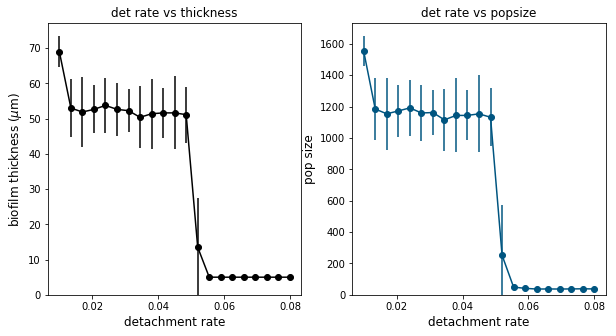

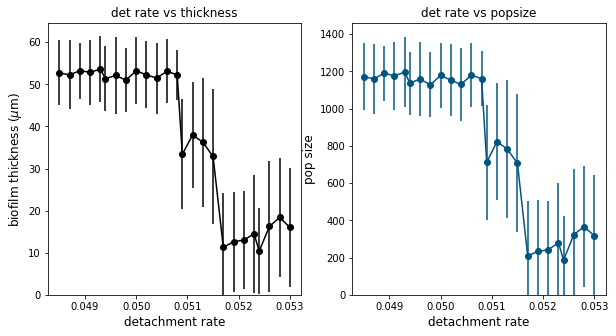

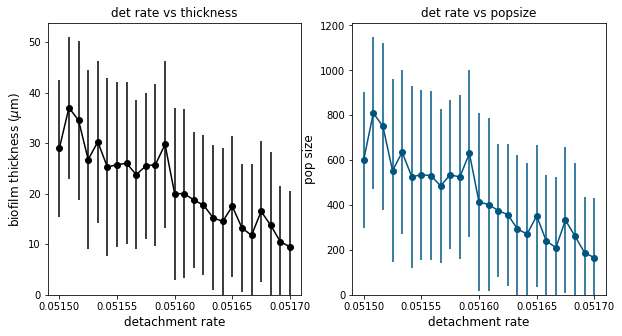

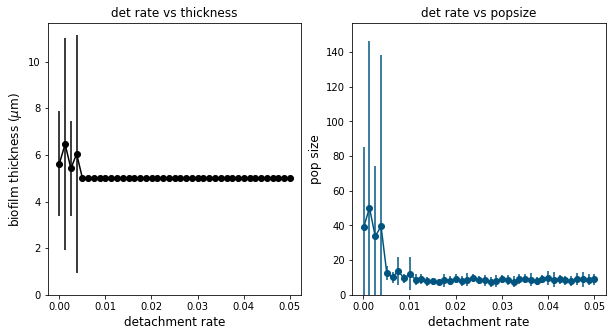

In [6]:
#plot_detach_rate_diagnostics_w_errors(precise_results,  'thickness-popsize_vs_detachrate_precise.pdf')
#plot_detach_rate_diagnostics_w_errors(precisest_results,  'thickness-popsize_vs_detachrate_precisest.pdf')
#plot_detach_rate_diagnostics_w_errors(precisest_results_2,  'thickness-popsize_vs_detachrate_precisest_2.pdf')

plot_detach_rate_diagnostics_w_errors(rough_results_REDO, 'optimal_detach_rate-rough.pdf')
plot_detach_rate_diagnostics_w_errors(precise_results_REDO, 'optimal_detach_rate-precise.pdf')
plot_detach_rate_diagnostics_w_errors(preciser_results_REDO, 'optimal_detach_rate-preciser.pdf')
plot_detach_rate_diagnostics_w_errors(chemical_rough_results, 'optimal_detach_rate_chemicals.pdf')

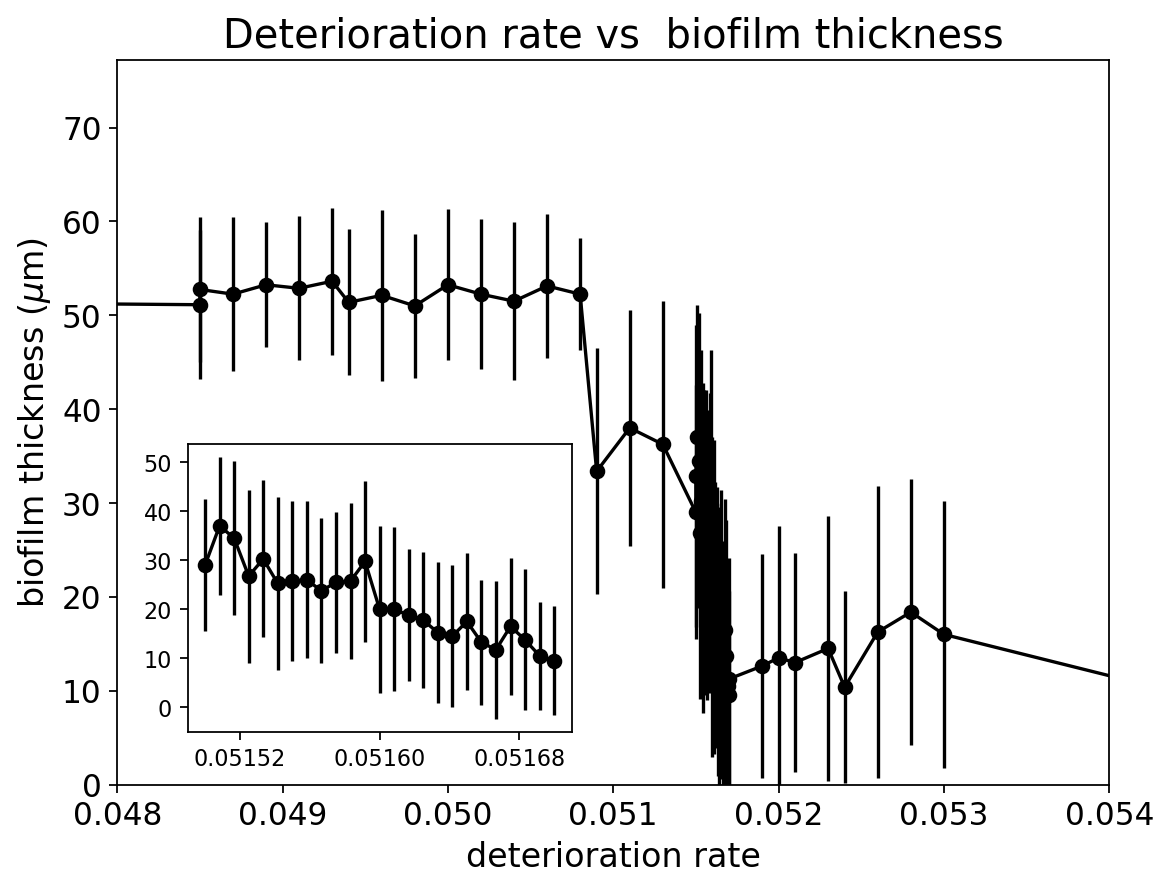

In [34]:
def collateAllResults_v2(results_matrix, pic_title):
    
    collated_results = []
    #print(len(results_matrix))
    #print(len(results_matrix[2]))
    
    for i in range(len(results_matrix[0])):
        collated_subresults = []
        for r in range(len(results_matrix)):
            collated_subresults += results_matrix[r][i]
        collated_results.append(np.array(collated_subresults))
   
    
    #now we sort the values, as the precise ones are in the middle of the rough ones
    idx = np.argsort(collated_results[0])
    
    for i in range(len(collated_results)):
        collated_results[i] = collated_results[i][idx]
    
    det_rs, thicknesses, thick_errs, pop_size, pop_errs = collated_results
    det_rs_prcs, thicknesses_prcs, thick_errs_prcs, pop_size_prcs, pop_errs_prcs = results_matrix[-1] #the precisest vals

    
    
    fig, axarr = plt.subplots(1, 1, dpi=160)
    fig.set_size_inches(8, 6)
    #fig.subplots_adjust(hspace=0.4)
    left, bottom, width, height = [0.18, 0.18, 0.3, 0.3]
    ax2 = fig.add_axes([left, bottom, width, height])

    thicknesses = [x*5.0 for x in thicknesses]
    thick_errs = [x*5.0 for x in thick_errs]
    thicknesses_prcs = [x*5.0 for x in thicknesses_prcs]
    thick_errs_prcs = [x*5.0 for x in thick_errs_prcs]
    
    pseudo_errs = [0. for x in range(len(thick_errs))]
    
    titleSize = 18
    labelSize = 15
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    axarr.errorbar(det_rs, thicknesses, yerr=thick_errs, fmt='-o', color='k')
    #axarr[1].errorbar(det_rs, pop_size, yerr=pseudo_errs, fmt='-o', color='#005580')
    ax2.errorbar(det_rs_prcs, thicknesses_prcs, yerr=thick_errs_prcs, fmt='-o', color='k')
    
    #ax.set_title('Varying detachment rate', fontsize=titleSize)
    axarr.set_title('Deterioration rate vs  biofilm thickness', fontsize=titleSize)
    axarr.set_xlabel('deterioration rate', fontsize=labelSize)
    axarr.set_ylabel('biofilm thickness ($\mu$m)', fontsize=labelSize)
    
    #axarr[1].set_title('det rate vs popsize', fontsize=titleSize)
    #axarr[1].set_xlabel('detachment rate', fontsize=labelSize)
    #axarr[1].set_ylabel('pop size', fontsize=labelSize)
    
    #for ax in axarr:
    axarr.locator_params(axis='x', nbins=6)
    axarr.xaxis.set_tick_params(labelsize=numbersize)
    axarr.yaxis.set_tick_params(labelsize=numbersize)
    axarr.set_xlim(0.048, 0.054)
    axarr.set_ylim(bottom=0)
    
    ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
    
    plt.savefig('plots/'+pic_title, bbox_inches='tight')
    plt.show()
    
    
        
collateAllResults_v2([rough_results_REDO, precise_results_REDO, preciser_results_REDO], 'collated_optimal_det_rates.pdf')

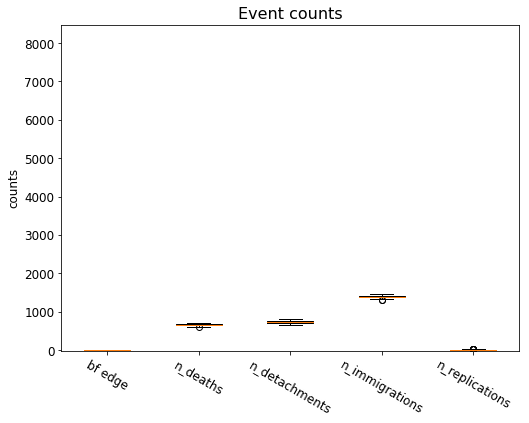

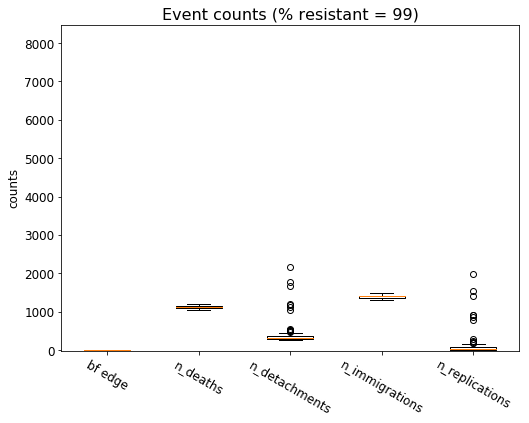

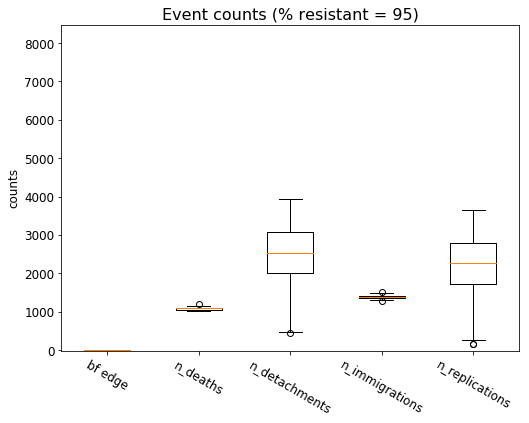

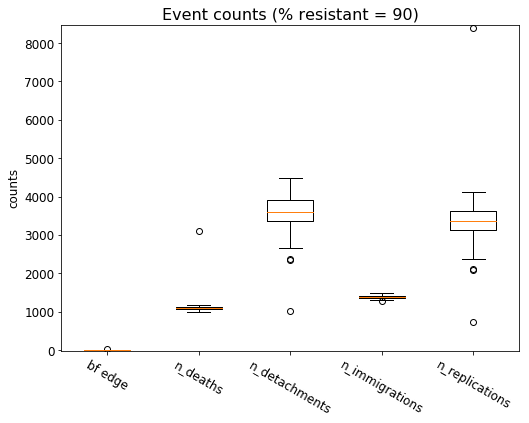

In [16]:
def box_plot_counters(counter_array_and_labels, pictitle, pc_resist_val=''):
    
    counter_labels, counter_array = counter_array_and_labels
        
    fig, ax = plt.subplots()
    
    fig.set_size_inches(8.2, 6)
    titleSize = 16
    labelSize = 12
    numbersize = 10
    legendsize = 10
    IDsize=12
    
    
    #ax.boxplot(counter_array, whis='range')
    ax.boxplot(counter_array)
    pc_label = ''
    if len(pc_resist_val) > 0:
        pc_label = ' (% resistant = '+pc_resist_val+')'
        
    ax.set_title('Event counts'+pc_label, fontsize=titleSize)
    ax.set_ylabel('counts', fontsize=labelSize)
    ax.set_ylim(-20, 8480)
    ax.set_xticklabels(counter_labels, rotation=-30)
    ax.tick_params(axis="x", labelsize=labelSize)
    ax.tick_params(axis="y", labelsize=labelSize)
    plt.savefig('plots/'+pictitle)
    plt.show()

    
box_plot_counters(event_counters_labels_testing, "event_counters_testing.pdf")
box_plot_counters(event_counters_labels_99res, "event_counters_99_resistant.pdf", '99')
box_plot_counters(event_counters_labels_95res, "event_counters_95_resistant.pdf", '95')
box_plot_counters(event_counters_labels_90res, "event_counters_90_resistant.pdf", '90')